In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import dynsys_reservoir as dynsys
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import PRA as pra
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
np.random.seed(42)  # For reproducibility

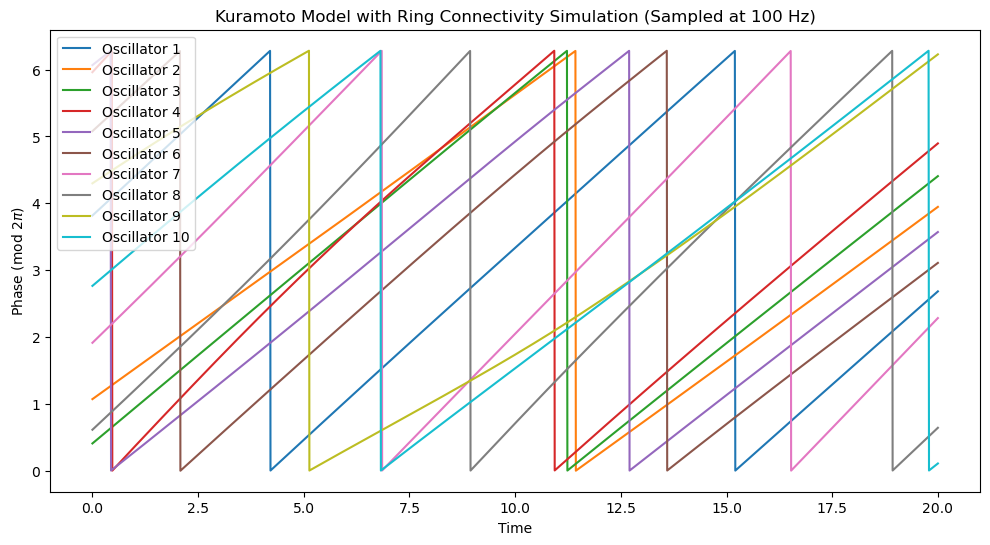

In [2]:
N = 25  # Number of oscillators

# Initialize the connectivity matrix with zeros
connectivity_matrix = np.zeros((N, N))

# Define ring connections (each oscillator connects to its two nearest neighbors on both sides)
for i in range(N):
    for j in [-2, -1, 1, 2]:  # Connect to the two nearest neighbors on each side
        connectivity_matrix[i, (i + j) % N] = 1

# Kuramoto model differential equations considering the connectivity matrix
def kuramoto_connected(t, y, omega, K, connectivity_matrix):
    dydt = np.zeros_like(y)
    for i in range(len(y)):
        connected_indices = np.where(connectivity_matrix[:, i])[0]
        dydt[i] = omega[i] + K / N * np.sum(np.sin(y[connected_indices] - y[i]))
    return dydt

# Parameters for simulation
sampling_rate = 100  # Hz
duration = 20  # seconds
t_span = (0, duration)
t_eval = np.linspace(*t_span, int(duration * sampling_rate))  # Ensuring 100 Hz sampling rate

omega = np.random.normal(0.5, 0.1, N)  # Natural frequencies
K = 1.0  # Coupling strength
y0 = np.random.uniform(0, 2*np.pi, N)  # Initial phases

# Solve the Kuramoto model with the specified connectivity
sol_kuramoto = solve_ivp(kuramoto_connected, t_span, y0, args=(omega, K, connectivity_matrix), t_eval=t_eval, method='RK45')

# Plotting a subset of the oscillators for clarity
plt.figure(figsize=(12, 6))
for i in range(min(N, 10)):  # Plot only the first 10 for clarity
    plt.plot(sol_kuramoto.t, np.mod(sol_kuramoto.y[i], 2*np.pi), label=f'Oscillator {i+1}')
plt.xlabel('Time')
plt.ylabel('Phase (mod $2\pi$)')
plt.title('Kuramoto Model with Ring Connectivity Simulation (Sampled at 100 Hz)')
plt.legend()
plt.show()

#Min max normalize
sol_kuramoto.y = (sol_kuramoto.y - np.min(sol_kuramoto.y))/(np.max(sol_kuramoto.y) - np.min(sol_kuramoto.y))


In [3]:
# Generate channel names
channel_names = [f"Channel {i+1}" for i in range(N)]
sim_data = np.array(sol_kuramoto.y)
info = mne.create_info(ch_names=channel_names,ch_types=["eeg"]*25, sfreq=100)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=20)

Creating RawArray with float64 data, n_channels=25, n_times=2000
    Range : 0 ... 1999 =      0.000 ...    19.990 secs
Ready.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


In [4]:
## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['A','B','C']
dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=0.01)

#PRA
pra_mat = pra.PRA(epochs.get_data())

Using data from preloaded Raw for 1 events and 2000 original time points ...
0 bad epochs dropped


  0%|          | 0/1 [00:00<?, ?it/s]

Using data from preloaded Raw for 1 events and 2000 original time points ...


  0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

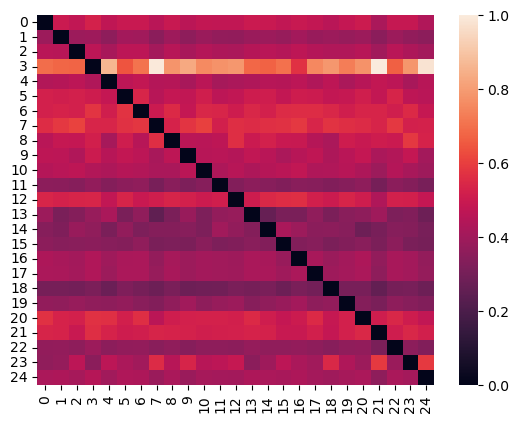

In [5]:
sns.heatmap(dynsys_mat)

<Axes: >

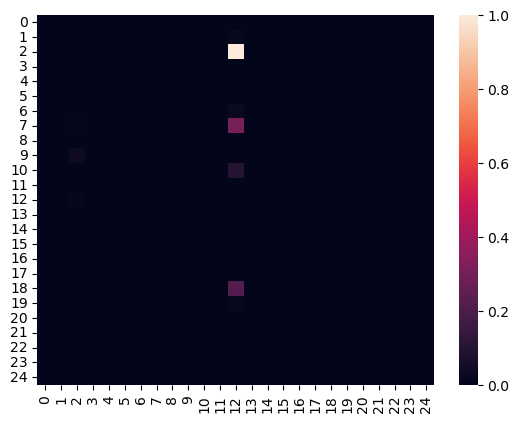

In [10]:
sns.heatmap(pra_mat)

<Axes: >

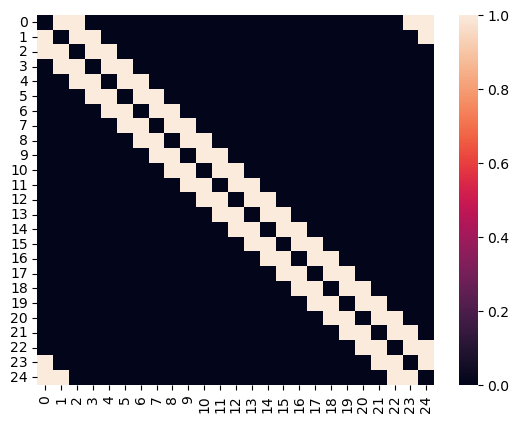

In [7]:
sns.heatmap(connectivity_matrix)

In [11]:



#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sampling_rate, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sampling_rate, fmin=8, fmax=13, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=100)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 300 connections
    using t=0.000s..19.990s for estimation (2000 points)
    frequencies: 8.0Hz..13.0Hz (101 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 300 connections
    using t=0.000s..19.990s for estimation (2000 points)
    frequencies: 8.0Hz..13.0Hz (101 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: ciPLV
    computing connectivity for epoch 1
    assembling connectivity matrix
[Connectivity computation done]
Using data from preloaded Raw for 1 events

Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 0 of 1 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 0 of 1 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 0 of 1 converged


Using data from preloaded Raw for 1 events and 2000 original time points ...


Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 0 of 1 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 0 of 1 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 0 of 1 converged
Computing the initial conditions using the Cholesky failed. Using a random initial condition.
Maximum iterations reached. 0 of 1 converged


Using data from preloaded Raw for 1 events and 2000 original time points ...


Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum it

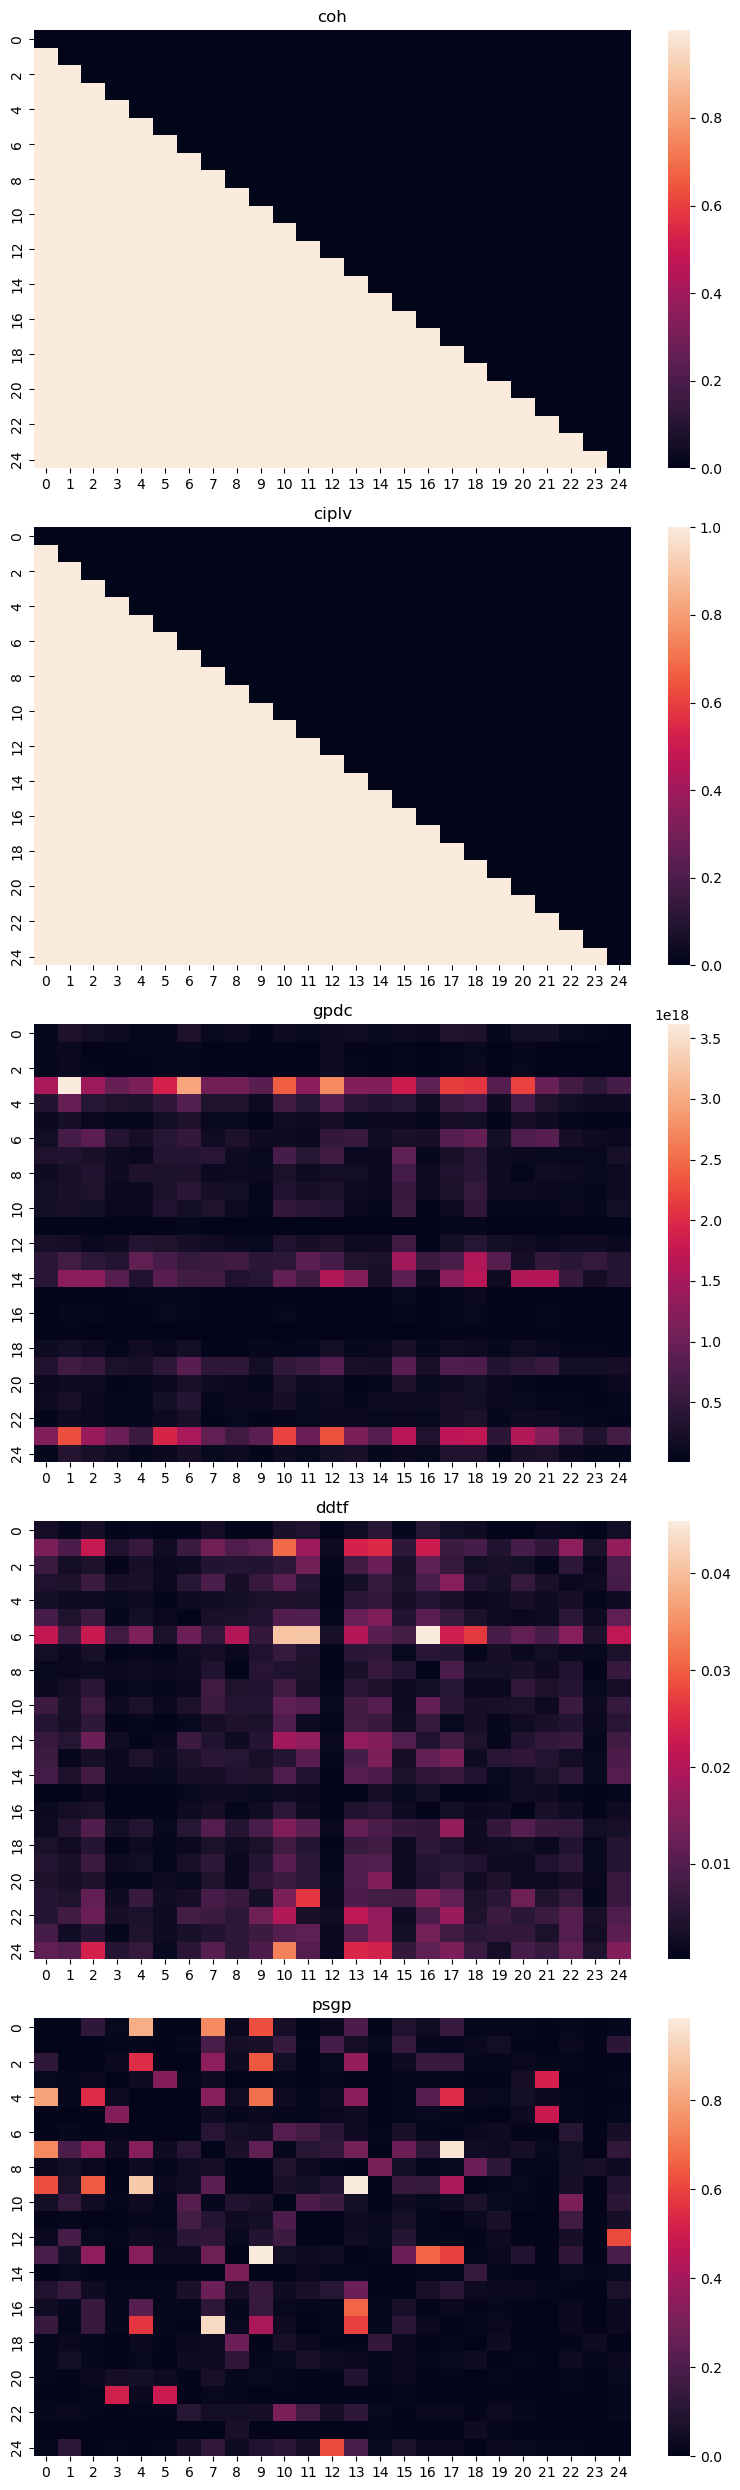

In [12]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(8,25))
sns.heatmap(coh_mat.mean(2), ax=ax1)
ax1.set_title('coh')

sns.heatmap(ciplv_mat.mean(2), ax=ax2)
ax2.set_title('ciplv')

sns.heatmap(gpdc_mat.mean(2), ax=ax3)
ax3.set_title('gpdc')

sns.heatmap(ddtf_mat.mean(2), ax=ax4)
ax4.set_title('ddtf')

sns.heatmap(psgp_mat.mean(2), ax=ax5)
ax5.set_title('psgp')
fig.tight_layout()
plt.show()

In [8]:
#Calculate MSE between ground truth and estimated connectivity matrices
mse_dynsys = np.mean((connectivity_matrix - dynsys_mat)**2)
mse_pra = np.mean((connectivity_matrix - pra_mat)**2)
print(f'MSE dynsys: {mse_dynsys}')
print(f'MSE pra: {mse_pra}')

MSE dynsys: 0.21648351265796592
MSE pra: 0.16150282487570647
